In [1]:
###########        sys_no: 1.  recurrent nonlinear system         
###########                2.  exponential nonlinear system 
###########    input_type: 1.    random sequence           
###########                2.    mean-zero white Gaussion noise with variance one
###########                3.    colored noise
###########     input_len:  length of input and output            
import numpy as np
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.random(input_len)
    elif(1==input_type): 
        input_raw=2*np.random.random(input_len)-1
    elif(2==input_type):
        input_raw=np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(1-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len))
    if(1==sys_no):
        for i in range(1,input_len): output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**2
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def JPPSOV_model01(input_data,desire_data,M_num,p_num,train,sort):
    nonlin_input_len=p_num+1;
    nonlin_weight_len=int(1+(p_num+1)+(p_num+1)*(p_num+2)/2)
    weight_nonlin = 0.001*(np.random.standard_normal(nonlin_weight_len))
    weight_linear = 0.001*(np.random.standard_normal(M_num))
    input_module=np.zeros(nonlin_input_len); input_post = np.ones(nonlin_weight_len)
    output_modul = np.zeros(M_num); output_filter = np.zeros(len(input_data))
    error=np.zeros_like(input_data)
    for j in range(M_num+p_num-2+1,len(input_data)):
        temp_w_sum=np.zeros(nonlin_weight_len);
        for jj in range(0,M_num):
        #for jj in range(M_num-1,-1,-1):
            if(jj==(M_num-1)) : 
                if(1==sort):
                    input_module[0]=output_modul[jj]
                else:
                    input_module[0]=input_data[j-jj-1]
            else : 
                input_module[0]=output_modul[jj+1]
            for jjj in range(1,p_num+1):
                input_module[jjj]=input_data[j-jj-(jjj-1)]         
            input_post[1:1+nonlin_input_len]=input_module[:]; SOVlen=0
            for k in range(0,nonlin_input_len):
                for kk in range(k,nonlin_input_len):
                    input_post[1+nonlin_input_len+SOVlen]=input_module[k]*input_module[kk]
                    SOVlen=SOVlen+1
            output_modul[jj]=np.dot(weight_nonlin,input_post.T)
            temp_w_sum=temp_w_sum+weight_linear[jj]*input_post
        output_filter[j]=np.dot(weight_linear,output_modul.T)
        error[j] = desire_data[j] - output_filter[j]
        gama=train[0]
        weight_linear = weight_linear+train[1]*error[j]*output_modul/(gama+np.linalg.norm(output_modul)**2)
        weight_nonlin = weight_nonlin+train[2]*error[j]*temp_w_sum/(gama+np.linalg.norm(temp_w_sum)**2)     
    return output_filter,error,weight_linear,weight_nonlin
def JPPSOV_model02(input_data,desire_data,M_num,p_num,train,sort):
    nonlin_input_len=p_num+1;
    nonlin_weight_len=int(1+(p_num+1)+(p_num+1)*(p_num+2)/2)
    weight_nonlin = 0.001*(np.random.standard_normal(M_num*nonlin_weight_len)).reshape(M_num,nonlin_weight_len)
    weight_linear = 0.001*(np.random.standard_normal(M_num))
    input_module=np.zeros(nonlin_input_len); input_post = np.ones(nonlin_weight_len)
    output_modul = np.zeros(M_num); output_filter = np.zeros(len(input_data))
    error=np.zeros_like(input_data)
    for j in range(M_num+p_num-2+1,len(input_data)):
        input_set=np.zeros_like(weight_nonlin);
        for jj in range(0,M_num):
        #for jj in range(M_num-1,-1,-1):
            if(jj==(M_num-1)) : 
                if(1==sort):
                    input_module[0]=output_modul[jj]
                else:
                    input_module[0]=input_data[j-jj-1]
            else : 
                input_module[0]=output_modul[jj+1]
            for jjj in range(1,p_num+1):
                input_module[jjj]=input_data[j-jj-(jjj-1)]         
            input_post[1:1+nonlin_input_len]=input_module[:]; SOVlen=0
            for k in range(0,nonlin_input_len):
                for kk in range(k,nonlin_input_len):
                    input_post[1+nonlin_input_len+SOVlen]=input_module[k]*input_module[kk]
                    SOVlen=SOVlen+1
            output_modul[jj]=np.dot(weight_nonlin[jj],input_post.T)
            input_set[jj,:]=input_post
        output_filter[j]=np.dot(weight_linear,output_modul.T)
        error[j] = desire_data[j] - output_filter[j]
        gama=train[0]
        for L in range(0,M_num):
            weight_nonlin[L,:] = weight_nonlin[L,:] + \
                                train[2]*error[j]*(weight_linear[L]*input_set[L])/(gama+np.linalg.norm(weight_linear[L]*input_set[L])**2)
        weight_linear = weight_linear+train[1]*error[j]*output_modul/(gama+np.linalg.norm(output_modul)**2)     
    return output_filter,error,weight_linear,weight_nonlin

In [7]:
N = 5000; M=5; p=1; apoch=100
train_para=np.array([ 1, 0.5, 0.02]) 
train_para=np.array([ 1, 0.5, 0.06]) 
train_para=np.array([ 1, 0.5, 0.1]) 
error2_sum_JPPSOV02=np.zeros(N);
for times in range(0,apoch):
    x_raw,d_raw,d_noise=input_set(2,1,N,0)  # Random Sequence
    output_filter,error_JPPSOV02,weight_lin,weght_non=JPPSOV_model01(x_raw,d_noise,M,p,train_para,0) #JPPSOV01
    error2_sum_JPPSOV02+=error_JPPSOV02**2
    if(0==times%50):
        print('apoch:',times,'JPPSOV01 ',10*np.log10(np.mean(error_JPPSOV02[-200:]**2)),'dB')
error2_sum_JPPSOV02/=apoch;
print('apoch:',apoch,'mean_MSE:','JPPSOV01',np.mean(error2_sum_JPPSOV02))

apoch: 0 JPPSOV01  -27.91092205043205 dB
apoch: 50 JPPSOV01  -28.195966600588775 dB
apoch: 100 mean_MSE: JPPSOV01 0.010671135924871615


In [3]:
def HPAVF_GSA_model(input_data,desire_data,train):
    M_num=2; p_num=2
    nonlin_input_len=p_num+1;
    nonlin_weight_len=int(1+(p_num+1)+(p_num+1)*(p_num+2)/2)
    weight_nonlin = 0.001*(np.zeros(M_num*nonlin_weight_len)).reshape(M_num,nonlin_weight_len)
    weight_linear = 0.001*(np.zeros(M_num))
    input_module=np.zeros(nonlin_input_len); input_post = np.ones(nonlin_weight_len);
    output_modul = np.zeros(M_num); output_filter = np.zeros(len(input_data))
    error=np.zeros_like(input_data)
    for j in range(M_num+p_num-2+1,len(input_data)):
        input_set=np.zeros(int(M_num)*nonlin_weight_len).reshape(M_num,nonlin_weight_len)
        module_sum=np.zeros(1)
        for jj in range(0,M_num):
        #for jj in range(M_num-1,-1,-1):
            if(jj==(M_num-1)) : 
                input_module[0]=input_data[j-jj-1]
            else : 
                input_module[0]=output_modul[jj+1]
            if(0==jj):
                input_module[2]=input_data[j-1]; input_module[1]=input_data[j-0]
            elif(1==jj):
                input_module[2]=0; input_module[1]=input_data[j-1]       
            input_post[1:1+nonlin_input_len]=input_module[:]; SOVlen=0
            for k in range(0,nonlin_input_len):
                for kk in range(k,nonlin_input_len):
                    input_post[1+nonlin_input_len+SOVlen]=input_module[k]*input_module[kk]
                    SOVlen=SOVlen+1
            output_modul[jj]=np.dot(weight_nonlin[jj,:],input_post.T)
            input_set[jj,:]=input_post
            module_sum=module_sum+output_modul[jj]
        output_filter[j]=np.dot(weight_linear,output_modul.T)+module_sum
        error[j] = desire_data[j] - output_filter[j]
        gama=train[0]
        weight_linear = weight_linear+train[1]*error[j]*output_modul/(gama+np.linalg.norm(output_modul)**2)
        for L in range(0,M_num):
            weight_nonlin[L,:] = weight_nonlin[L,:]+train[2]*error[j]*input_set[L,:]/(gama+np.linalg.norm(input_set[L,:])**2)     
    return output_filter,error,weight_linear,weight_nonlin
N = 5000; apoch=100
train_para_GSAHPAVF=np.array([1, 0.5 ,0.1]) 
error2_sum_GSAHPAVF=np.zeros(N); 
for times in range(0,apoch):
    x_raw,d_raw,d_noise=input_set(2,1,N,0)
    output_filter,error_GSAHPAVF,weight_lin,weght_non=HPAVF_GSA_model(x_raw,d_noise,train_para_GSAHPAVF)  
    error2_sum_GSAHPAVF+=error_GSAHPAVF**2;
    if(0==times%50):
        print('apoch:',times,' ',10*np.log10(np.mean(error_GSAHPAVF[N-5-101:N-5-1]**2)))
error2_sum_GSAHPAVF/=apoch;
print('apoch:',times,'mean_MSE:',np.mean(error2_sum_GSAHPAVF)) 

apoch: 0   -27.974129287966974
apoch: 50   -28.75504898037111
apoch: 99 mean_MSE: 0.004061787461728485


C:\Users\Administrator\AppData\Local\Temp/ipykernel_9024/869173372.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N), 10*np.log10(error2_sum_GSAHPAVF), color='#F00CC5',label="GSA-JPPSOV",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_9024/869173372.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N), 10*np.log10(error2_sum_JPPSOV02), color='#1887F0',label="JPPSOV",linewidth=0.6)


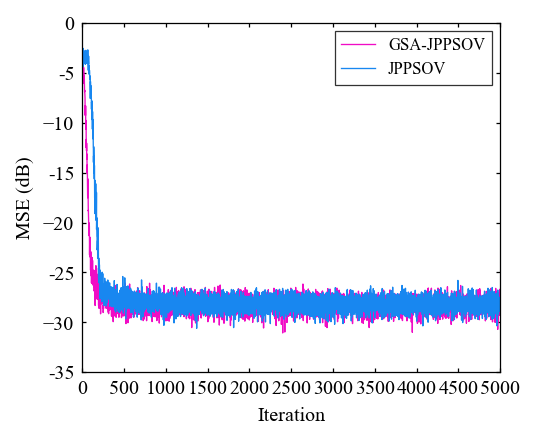

In [8]:
import matplotlib as mpl;import matplotlib.pyplot as plt;import copy
import matplotlib.font_manager as fm;from matplotlib.ticker import MultipleLocator,AutoMinorLocator
# 图片大小,单位厘米
fw = 8.69/2.54; fh = 7.18/2.54 
# 设置全局的字体
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.stretch'] ='normal'
mpl.rcParams['font.size'] = 9
font0 = {'fontfamily': 'serif',
         'fontname': 'Times New Roman',
         'fontstyle': 'normal',
         'fontvariant': 'normal',
         'fontweight': 'normal',
         'fontstretch': 'normal',
         'fontsize': 9}
tick_font = fm.FontProperties(family='Times New Roman', style='normal', variant='normal', weight='normal',
                           stretch='normal', size=9)

fig = plt.figure(figsize=(fw,fh),dpi=160);    
ax = fig.add_subplot(111)

plt.plot(np.arange(N), 10*np.log10(error2_sum_GSAHPAVF), color='#F00CC5',label="GSA-JPPSOV",linewidth=0.6)
#plt.plot(np.arange(N), 10*np.log10(error2_sum_SOV), color='#37F500', label="SOV", linewidth=0.6)
plt.plot(np.arange(N), 10*np.log10(error2_sum_JPPSOV02), color='#1887F0',label="JPPSOV",linewidth=0.6)

ax.set_xlim(0,N); ax.set_ylim(-35,0);
ax.tick_params(which='major',length=2,width=0.57,bottom=True, top=True, left=True, right=True);
ax.tick_params(which='minor',length=1.7,width=0.57,bottom=True, top=True, left=True, right=True)
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="both", which='both', direction="in") 
ax.xaxis.set_major_locator(MultipleLocator(base=1000))
ax.xaxis.set_minor_locator(MultipleLocator(base=500))
ax.xaxis.set_minor_formatter((mpl.ticker.FormatStrFormatter('%.0f')))
ax.yaxis.set_major_locator(MultipleLocator(base=10))
ax.yaxis.set_minor_locator(MultipleLocator(base=5))
ax.yaxis.set_minor_formatter((mpl.ticker.FormatStrFormatter('%.0f')))
# 设置tick_label字体
for xtlabel in ax.get_xticklabels():
    xtlabel.set_fontproperties(tick_font)
for ytlabel in ax.get_yticklabels():
    ytlabel.set_fontproperties(tick_font)
# 设置图形变宽线宽度和颜色
bwith = 0.57
ax.spines['left'].set_color((0,0,0,1))
ax.spines['left'].set_linewidth(bwith)
ax.spines['right'].set_color((0,0,0,1))
ax.spines['right'].set_linewidth(bwith)
ax.spines['top'].set_color((0,0,0,1))
ax.spines['top'].set_linewidth(bwith)
ax.spines['bottom'].set_color((0,0,0,1))
ax.spines['bottom'].set_linewidth(bwith)
# 设置图形坐标轴标签和标题字体
ax.set_xlabel('Iteration',fontdict=font0)  
ax.set_ylabel('MSE (dB)',fontdict=font0)  
ax.legend(loc='upper right',frameon=True,edgecolor='black',facecolor='white',\
          shadow=False,fancybox=False,fontsize='small').get_frame().set_linewidth(0.57) 
plt.tight_layout()   
#fig.savefig('D:\\Postgraduatee\\sketch\photo\\S6dot25\\sys_exp_random.PNG', bbox_inches='tight', dpi=1200)
plt.show();